## Twin Delayed Deep Deterministic Policy Gradient

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import collections
import random
import numpy as np
import copy

## Environment
env = gym.make('Pendulum-v0')


## Action이 연속적이라 env.action_space.n을 사용하지않음.
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

## Hyperparameter
actor_learning_rate = 0.001
critic_learning_rate = 0.001
batch_size = 100
discount_factor = 0.99
tau = 0.005
max_episode_num = 5000

## 결과값 프린트 주기
print_interval = 10


# Element
* 에이전트(Agent) : Pendulum agent
* 환경(Enviornment) : Pendulum , 
* 상태(State) : cosine(theta) , sine(theta) , theta dot
* 행동(Action)  : Joint Effort
* 정책(Policy) : Actor 네트워크 + select Action 
    Actor Network를 통해 나온 값을 Select Actin에 넣어서 결정
* 보상(Reward) : -(theta^2 + 0.1*theta_dot^2 + 0.001*action^2)
* 에피소드(Episode) : Episode의 끝에 기준은 없지만 목적은 추를 위로 세우는 것이다. 
* 감가율(Discount Factor) : Gamma / 
* 행동 가치(State-Action-Value) :Critic 네트워크를 통해 나온 계산 값
* Exploration method : Normal distribution(Action 값에 정규분포에 random 값을 더해서 noise를 추가시켜 Exploration을 하게한다.
* Off - policy : Using Replay Buffer / Critic : Policy_net & Target_net(2개) Actor : Policy_net & Target_net 

# Algorithm
* TD3 Algorithm & LOSS : DDPG 알고리즘의 문제점인 Q-value의 과대평가 문제를 보완한 알고리즘이다.2개의 Critic Network를 만들어 계산 값 중 min 값을 택해 과대평가 되는 것을 막고, Actor netwokr의 업데이트 속도가 Critic보다 느리게 업데이트한다.
    TD-error : Q(s,a) - reward + discout reward * Q(s',a') 이고 이때 MSE Loss 를 이용한다. 이를 통해서 Critic을 학습하고 Critic을 이용해 Actor를 학습한다. Critic의 Q-functino이 Action에 대하여 미분가능하다고 가정하기 때문에 Gradient Ascent를 이용한다.

     Q Network가 2개이므로 Loss를 정의할 때 backup_value를 이용한다.Backup_value는  두 개의 Q_target_network에서 나온 값에 min을 이용해 정의하며, 전체 Critic의 Loss는 backup_value를 기준으로 각 Q network의 mse loss의 합으로 한다.
    또한 Actor의 Loss는 Critic이 현재 State와 Actor가 계산한 Action을 평가한다. 이때 Critic은 Q-network 중 하나의 네트워크를 이용한다.
    loss = -Critic(State, Actor(state)) 을 통해서 계산한다.


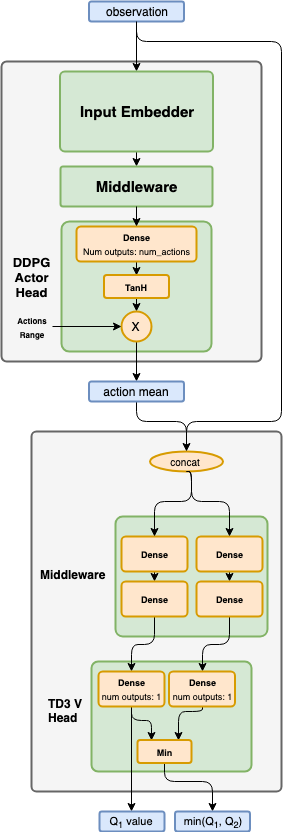
reference : https://nervanasystems.github.io/coach/components/agents/policy_optimization/td3.html

In [2]:
## Noise Generator /// Td3 는 target action에 노이즈를 추가한다. 
class Noisegenerator : 
    def __init__(self,mean,sigma):
        self.mean = mean
        self.sigma = sigma
    def generate(self) :
        return np.random.normal(self.mean,self.sigma,1)[0]


## Replay_Buffer(Experience Replay) => Off-policy
class Replay_buffer():
    def __init__(self,max_size = 100000):
        self.memory = []
        self.max_size = max_size
        self.position = 0
        self.buffer_size = 0
    def push(self,data):
        if len(self.memory) == self.max_size:
            self.memory[int(self.position)] = data
            self.position = (self.position + 1) % self.max_size
        else : 
            self.memory.append(data)
            self.buffer_size += 1
            
    def sample(self,batch_size) :
        ind = np.random.randint(0, len(self.memory), size=batch_size)
        states, actions, next_states, rewards, done = [], [], [], [], []
        ## state , action, next_state , done , reward에 따라 나눔
        
        
        ## 받은 샘플들을 합쳐서 내보냄
        for i in ind:
            state, action, next_state, reward, done_ = self.memory[i]
            states.append([state])
            actions.append([action])
            next_states.append([next_state])
            rewards.append([reward])
            done.append([done_])
        ## Return 값이 각 요소에 따른 텐서들을 전달
        return torch.tensor(states,dtype = torch.float), torch.tensor(actions,dtype = torch.float), \
                torch.tensor(next_states,dtype = torch.float), torch.tensor(rewards,dtype = torch.float), torch.tensor(done,dtype = torch.float)

    def size(self) :
        return self.buffer_size
        
        
## Network는 학습 속도를 위해 변화할 수 있음 / Network Size는 상황에 따라 조정
## 후에 Noisy action을 위해서 critic network에 2개의 변수를 받는 걸로 변환
    
class Actor_network(nn.Module):
    def __init__(self):
            super(Actor_network,self).__init__()
            self.fc1 = nn.Linear(state_dim,128)
            self.fc2 = nn.Linear(128,64)
            self.fc3 = nn.Linear(64,action_dim)
            
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        ## Action의 범위 생각
        x = torch.tanh(self.fc3(x))*2
        return x

class Critic_network(nn.Module):
    def __init__(self,state_dim,action_dim):
        super(Critic_network,self).__init__()
        
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc_1 = nn.Linear(action_dim, 64)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,1)

    def forward(self,x,y):
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc_1(y))
        x = x.squeeze()
        y = y.squeeze()
        x = torch.cat([x,y],dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

        


#Pseudo Code
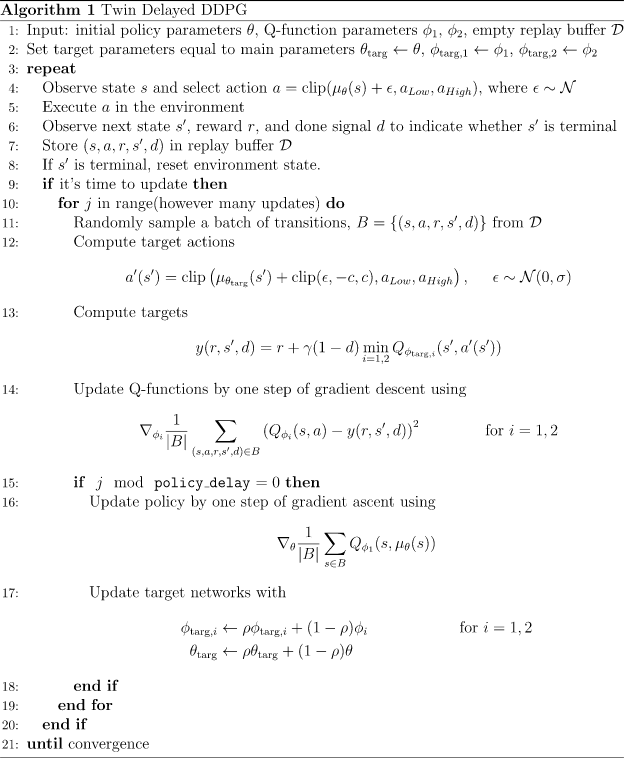

reference : https://spinningup.openai.com/en/latest/algorithms/td3.html

In [3]:
class TD3(nn.Module):
    
    def __init__(self):
        super(TD3,self).__init__()
        
        ## Twin Q network
        self.critic1_network = Critic_network(state_dim,action_dim)
        self.critic2_network = Critic_network(state_dim,action_dim)
        
        ## Optimize 할 때 두개의 네트워크를 같이함.
        self.critic_network_optimizer = optim.Adam(list(self.critic1_network.parameters()) \
                                              + list(self.critic2_network.parameters()) ,lr = critic_learning_rate)
        
        ## Actor Network 설정
        self.actor_network = Actor_network()
        self.actor_network_optimizer = optim.Adam(self.actor_network.parameters(),lr = actor_learning_rate)
        
        
        ## Target Network를 생성 
        ## DeepCopy를 이용함. 서로 영향을 안줌
        
        self.critic1_target_network = copy.deepcopy(self.critic1_network)
        self.critic2_target_network = copy.deepcopy(self.critic2_network)
        self.actor_target_network = copy.deepcopy(self.actor_network)
        
        self.noise_generator = Noisegenerator(0,0.2)
        
        ## TD3 는 Delayed 라는 특성을 가지고 있음
        self.train_num = 1
        self.delay = 2
        
    def train_net(self) :
        state ,action ,reward , next_state ,done = memory.sample(batch_size)
        
        
        
        ## Cliping 과 noise를 추가함. / Exploration 효과
        ## Pseudo Code 12,13번 참고
        noisy_action = self.actor_target_network(next_state) + torch.tensor(np.clip(self.noise_generator.generate(),-0.5,0.5))
        noisy_action = torch.clamp(noisy_action,-2,2).detach()
        
        ## Twin 이기 때문에 2개의 네트워크에서 값을 가져옴
        backup_value = reward + discount_factor * torch.min(self.critic1_target_network(next_state,noisy_action),\
                                                    self.critic2_target_network(next_state,noisy_action))
        
        ## 두개의 네트워크를 이용해 MSBE loss 구함
        ## Pseudo Code 14번 참고
        q_loss = F.mse_loss(backup_value.detach(),self.critic1_network(state,action)) \
                + F.mse_loss(backup_value.detach(),self.critic2_network(state,action))
        
        ## Optimizer (Critic Network)
        self.critic_network_optimizer.zero_grad()
        q_loss.backward()
        self.critic_network_optimizer.step()
        
        ## Delay (Optimize 하는 시간이 즉각적으로 이루어지지않음)
        ## Pseudo Code 15,16번 참고
        if self.train_num % self.delay ==0 :
            ## Optimizer (Actor Network)
            actor_loss = -self.critic1_network(state,self.actor_network(state)).mean()
            self.actor_network_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_network_optimizer.step()
            
            ## Parameter Copy
            ## Pseudo code 17번 참고 / Polyak Average
            for param, target_param in zip(self.critic1_network.parameters(),self.critic1_target_network.parameters()):
                target_param.data.copy_(tau * param.data + (1-tau) * target_param.data)
            for param, target_param in zip(self.critic2_network.parameters(),self.critic2_target_network.parameters()):
                target_param.data.copy_(tau * param.data + (1-tau) * target_param.data)
            for param, target_param in zip(self.actor_network.parameters(),self.actor_target_network.parameters()):
                target_param.data.copy_(tau * param.data + (1-tau) * target_param.data)   
        
        self.train_num +=1

In [4]:
## Plot 으로 결과확인하기

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(list_total_reward)
    plt.title('Training')
    plt.xlabel('num of episode / 10')
    plt.ylabel('reward / 10')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

# 전에 사용했던 모델 가져오기! 
## 변수 다시 사용하기위해서

In [5]:

## Train
total_reward = 0

agent = TD3()
memory = Replay_buffer()



'''
## 전에 사용했던 모델 있는 곳
PATH = 'C:/Users/joker/Pytorch//model data/td3.pth'
## 전에 사용했던 모델 가져오기 
load = False
if load == True :
    temp = torch.load(PATH)
    agent.load_state_dict(temp['model_state_dict'])
    agent.eval() 
    
sample = Actor_network()
state = env.reset()
print(type(torch.from_numpy(state).float()))
writer.add_graph(sample,torch.from_numpy(state).float())
'''

"\n## 전에 사용했던 모델 있는 곳\nPATH = 'C:/Users/joker/Pytorch//model data/td3.pth'\n## 전에 사용했던 모델 가져오기 \nload = False\nif load == True :\n    temp = torch.load(PATH)\n    agent.load_state_dict(temp['model_state_dict'])\n    agent.eval() \n    \nsample = Actor_network()\nstate = env.reset()\nprint(type(torch.from_numpy(state).float()))\nwriter.add_graph(sample,torch.from_numpy(state).float())\n"

# of episode : 4990, average score : -241.1


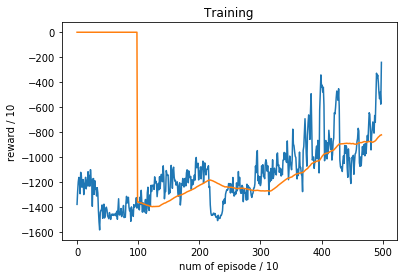

In [6]:
## Train
list_total_reward = []
noise_generator = Noisegenerator(0,0.1)

for num_episode in range(max_episode_num) :
    state = env.reset()
    global_step = 0
    done = False
    reward = 0
    while not done :
        global_step += 1
        action = agent.actor_network(torch.from_numpy(state).float()).item()
        ## noise 추가
        action += noise_generator.generate()

        ## Action 값이 범위를 넘어서지 않도록 설정
        action = max(min(action,2),-2)
        next_state , reward , done , _ = env.step([action])
        ## Replay Buffer의 저장

        memory.push((state,action,reward/100.0,next_state,done))

        state = next_state

        total_reward += reward

        if done :
            break
    ## Memory size가 커지고 나서 학습시작
    if memory.size()>1000:
        
        agent.train_net()
    ## 결과값 프린트
    if num_episode % print_interval == 0 and num_episode !=0 :
        clear_output()

        print("# of episode : {}, average score : {:.1f}".format(num_episode, \
                                                                 total_reward/print_interval))
        list_total_reward.append(total_reward/print_interval)
        total_reward = 0.0
        

    plot_durations()
        
## 모델 저장하기 ! 
torch.save({
            'model_state_dict': agent.state_dict(),
            }, 'PATH.pth')
        
        


Comments : 